In [1]:
%pylab inline

from collections import defaultdict
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

from evaluator import Evaluator
from my_dataset_handler import DatasetHandler

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset100k = "ml-100k"

In [3]:
dataset_handler = DatasetHandler(dataset100k)

In [4]:
class CollaborativeFilteringRecommender(object):
    def __init__(self, dataset_handler, neighbours_to_predict=5):
        self.dataset_handler = dataset_handler
        self.movies_vectors = self.dataset_handler.load_movies()
        self.movies_ids = set(self.dataset_handler.id_to_title.keys())
        self.neighbours_to_predict = neighbours_to_predict
    
    def train(self, train_set):
        self.users_ratings = train_set
        self.users_profiles, self.user_id_to_profile_index = self._create_users_profiles(train_set)
        self.movies_watchers = self._get_movies_watchers(train_set)
        self.nbrs = NearestNeighbors(metric='cosine', algorithm='brute')
    
    def top(self, user_profile, topN):
        unrated_movies = np.array([
            (movieId, self.predict_rating(user_profile, movieId))
            for movieId in list(self.movies_ids - user_profile[1])
        ])
        return unrated_movies[np.argpartition(-unrated_movies[:, 1], topN)[:topN], 0]
    
    def predict_rating(self, user_profile, movieId):
        profiles_with_ids = np.array([
            np.hstack([[watcher], self.users_profiles[self.user_id_to_profile_index[watcher]][0]])
            for watcher in self.movies_watchers[movieId]
        ])
        nearest_neighbours = self._cosineKNN(user_profile, profiles_with_ids, self.neighbours_to_predict)
        if not nearest_neighbours:
            return 0.0
        return np.average([self.users_ratings[neighbour][movieId] for neighbour in nearest_neighbours])
    
    def create_user_profile(self, user_ratings):
        mid_rating=2.75
        profile = np.average(
            np.array([
                self.movies_vectors[self.dataset_handler.id2index(movie)]*np.sign(rating - mid_rating)
                for (movie, rating) in user_ratings.items()
            ]),
            weights=(mid_rating-np.array(user_ratings.values()))**2,
            axis=0
        )
        watched_movies = set(user_ratings.keys())
        return (profile, watched_movies)
    
    def present_user(self, user_profile, user_ratings):
        print "User favourite genre:", self.dataset_handler.feature_index2genre(np.argmax(user_profile[0]))
        print "User ratings:"
        for (movieId, rating) in user_ratings.items():
            movie_vector = self.movies_vectors[self.dataset_handler.id2index(movieId)]
            print "{} {}: {}".format(
                self.dataset_handler.id_to_title[movieId],
                self.dataset_handler.movie_vector2genres(movie_vector),
                rating
            )
    
    def present_recommendations(self, recommendations):
        print "Recommended movies:"
        for movieId in recommendations:
            movie_vector = self.movies_vectors[self.dataset_handler.id2index(movieId)]
            print "{} {}".format(
                self.dataset_handler.id_to_title[movieId],
                self.dataset_handler.movie_vector2genres(movie_vector)
            )
    
    def _get_movies_watchers(self, users_ratings):
        movies_watchers = defaultdict(list)
        for (user, user_ratings) in users_ratings.items():
            for movieId in user_ratings.keys():
                movies_watchers[movieId].append(user)
        return movies_watchers
    
    def _create_users_profiles(self, users_ratings):
        users_profiles = []
        user_id_to_profile_index = {}
        for i, (user, user_ratings) in enumerate(users_ratings.items()):
            users_profiles.append(self.create_user_profile(user_ratings))
            user_id_to_profile_index[user] = i
        return users_profiles, user_id_to_profile_index
    
    def _cosineKNN(self, user_profile, profiles_with_ids, k, treshold=20):
        if profiles_with_ids.shape[0] < treshold:
            return []
        self.nbrs.fit(profiles_with_ids[:, 1:])
        return [
            profiles_with_ids[i, 0]
            for i in self.nbrs.kneighbors(np.array([user_profile[0]]), n_neighbors=min(k, len(profiles_with_ids)), return_distance=False)[0]
        ]

In [7]:
recommender = CollaborativeFilteringRecommender(dataset_handler, 20)
users_ratings = dataset_handler.load_users_ratings()
users_ratings

{1: {1: 5,
  2: 3,
  3: 4,
  4: 3,
  5: 3,
  6: 5,
  7: 4,
  8: 1,
  9: 5,
  10: 3,
  11: 2,
  12: 5,
  13: 5,
  14: 5,
  15: 5,
  16: 5,
  17: 3,
  18: 4,
  19: 5,
  20: 4,
  21: 1,
  22: 4,
  23: 4,
  24: 3,
  25: 4,
  26: 3,
  27: 2,
  28: 4,
  29: 1,
  30: 3,
  31: 3,
  32: 5,
  33: 4,
  34: 2,
  35: 1,
  36: 2,
  37: 2,
  38: 3,
  39: 4,
  40: 3,
  41: 2,
  42: 5,
  43: 4,
  44: 5,
  45: 5,
  46: 4,
  47: 4,
  48: 5,
  49: 3,
  50: 5,
  51: 4,
  52: 4,
  53: 3,
  54: 3,
  55: 5,
  56: 4,
  57: 5,
  58: 4,
  59: 5,
  60: 5,
  61: 4,
  62: 3,
  63: 2,
  64: 5,
  65: 4,
  66: 4,
  67: 3,
  68: 4,
  69: 3,
  70: 3,
  71: 3,
  72: 4,
  73: 3,
  74: 1,
  75: 4,
  76: 4,
  77: 4,
  78: 1,
  79: 4,
  80: 4,
  81: 5,
  82: 5,
  83: 3,
  84: 4,
  85: 3,
  86: 5,
  87: 5,
  88: 4,
  89: 5,
  90: 4,
  91: 5,
  92: 3,
  93: 5,
  94: 2,
  95: 4,
  96: 5,
  97: 3,
  98: 4,
  99: 3,
  100: 5,
  101: 2,
  102: 2,
  103: 1,
  104: 1,
  105: 2,
  106: 4,
  107: 4,
  108: 5,
  109: 5,
  110: 1,
  111

In [8]:
user_ratings = users_ratings[17]
user_ratings

{1: 4,
 7: 4,
 9: 3,
 13: 3,
 100: 4,
 111: 3,
 117: 3,
 125: 1,
 126: 4,
 137: 4,
 150: 5,
 151: 4,
 221: 2,
 222: 3,
 237: 2,
 243: 1,
 245: 2,
 269: 4,
 276: 4,
 286: 3,
 294: 4,
 323: 1,
 471: 2,
 475: 4,
 508: 3,
 628: 1,
 744: 3,
 919: 4}

In [9]:
del users_ratings[17]
users_ratings

{1: {1: 5,
  2: 3,
  3: 4,
  4: 3,
  5: 3,
  6: 5,
  7: 4,
  8: 1,
  9: 5,
  10: 3,
  11: 2,
  12: 5,
  13: 5,
  14: 5,
  15: 5,
  16: 5,
  17: 3,
  18: 4,
  19: 5,
  20: 4,
  21: 1,
  22: 4,
  23: 4,
  24: 3,
  25: 4,
  26: 3,
  27: 2,
  28: 4,
  29: 1,
  30: 3,
  31: 3,
  32: 5,
  33: 4,
  34: 2,
  35: 1,
  36: 2,
  37: 2,
  38: 3,
  39: 4,
  40: 3,
  41: 2,
  42: 5,
  43: 4,
  44: 5,
  45: 5,
  46: 4,
  47: 4,
  48: 5,
  49: 3,
  50: 5,
  51: 4,
  52: 4,
  53: 3,
  54: 3,
  55: 5,
  56: 4,
  57: 5,
  58: 4,
  59: 5,
  60: 5,
  61: 4,
  62: 3,
  63: 2,
  64: 5,
  65: 4,
  66: 4,
  67: 3,
  68: 4,
  69: 3,
  70: 3,
  71: 3,
  72: 4,
  73: 3,
  74: 1,
  75: 4,
  76: 4,
  77: 4,
  78: 1,
  79: 4,
  80: 4,
  81: 5,
  82: 5,
  83: 3,
  84: 4,
  85: 3,
  86: 5,
  87: 5,
  88: 4,
  89: 5,
  90: 4,
  91: 5,
  92: 3,
  93: 5,
  94: 2,
  95: 4,
  96: 5,
  97: 3,
  98: 4,
  99: 3,
  100: 5,
  101: 2,
  102: 2,
  103: 1,
  104: 1,
  105: 2,
  106: 4,
  107: 4,
  108: 5,
  109: 5,
  110: 1,
  111

In [10]:
recommender.train(users_ratings)
user_profile = recommender.create_user_profile(user_ratings)
user_profile

(array([-0.09395973,  0.08724832,  0.04194631,  0.        ,  0.22483221,
        -0.04026846,  0.        ,  0.16946309,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.05201342,  0.08557047,
        -0.05369128, -0.02684564,  0.        ]),
 {1,
  7,
  9,
  13,
  100,
  111,
  117,
  125,
  126,
  137,
  150,
  151,
  221,
  222,
  237,
  243,
  245,
  269,
  276,
  286,
  294,
  323,
  471,
  475,
  508,
  628,
  744,
  919})

In [11]:
recommender.present_user(user_profile, user_ratings)

User favourite genre: Comedy
User ratings:
Toy Story (1995) ['Animation', 'Comedy']: 4
Twelve Monkeys (1995) ['Drama', 'Sci-Fi']: 4
Dead Man Walking (1995) ['Drama']: 3
Willy Wonka and the Chocolate Factory (1971) ['Adventure', 'Comedy']: 4
Mighty Aphrodite (1995) ['Comedy']: 3
Leaving Las Vegas (1995) ['Drama', 'Romance']: 4
Swingers (1996) ['Comedy', 'Drama']: 5
City of Lost Children, The (1995) ['Adventure', 'Sci-Fi']: 4
English Patient, The (1996) ['Drama', 'Romance', 'War']: 3
Liar Liar (1997) ['Comedy']: 4
Big Night (1996) ['Drama']: 4
Rock, The (1996) ['Action', 'Adventure', 'Thriller']: 3
Dante's Peak (1997) ['Action', 'Thriller']: 1
Full Monty, The (1997) ['Comedy']: 4
Courage Under Fire (1996) ['Drama', 'War']: 2
Trainspotting (1996) ['Drama']: 4
Breaking the Waves (1996) ['Drama']: 2
Star Trek: First Contact (1996) ['Action', 'Adventure', 'Sci-Fi']: 3
Fargo (1996) ['Crime', 'Drama', 'Thriller']: 4
Michael Collins (1996) ['Drama', 'War']: 3
Jerry Maguire (1996) ['Drama', 'Rom

In [25]:
top = recommender.top(user_profile, topN=25)
top

array([ 182.,   64.,  275.,  272.,   69.,   98.,  303.,  315.,  124.,
         14.,  127.,  318.,  483.,  179.,  216.,  340.,  197.,  285.,
         23.,  750.,  357.,  238.,   12.,  582.,  427.])

In [26]:
recommender.present_recommendations(top)

Recommended movies:
GoodFellas (1990) ['Crime', 'Drama']
Shawshank Redemption, The (1994) ['Drama']
Sense and Sensibility (1995) ['Drama', 'Romance']
Good Will Hunting (1997) ['Drama']
Forrest Gump (1994) ['Comedy', 'Romance', 'War']
Silence of the Lambs, The (1991) ['Drama', 'Thriller']
Ulee's Gold (1997) ['Drama']
Apt Pupil (1998) ['Drama', 'Thriller']
Lone Star (1996) ['Drama', 'Mystery']
Postino, Il (1994) ['Drama', 'Romance']
Godfather, The (1972) ['Action', 'Crime', 'Drama']
Schindler's List (1993) ['Drama', 'War']
Casablanca (1942) ['Drama', 'Romance', 'War']
Clockwork Orange, A (1971) ['Sci-Fi']
When Harry Met Sally... (1989) ['Comedy', 'Romance']
Boogie Nights (1997) ['Drama']
Graduate, The (1967) ['Drama', 'Romance']
Secrets & Lies (1996) ['Drama']
Taxi Driver (1976) ['Drama', 'Thriller']
Amistad (1997) ['Drama']
One Flew Over the Cuckoo's Nest (1975) ['Drama']
Raising Arizona (1987) ['Comedy']
Usual Suspects, The (1995) ['Crime', 'Thriller']
Piano, The (1993) ['Drama', 'Roma

In [14]:
evaluator = Evaluator(CollaborativeFilteringRecommender(dataset_handler, 20))
evaluator.computeRMSE()

0.95130580674515264

In [15]:
evaluator.computeMAP()

0.1942234580979287

In [16]:
class CollaborativeFilteringWithClusteringRecommender(CollaborativeFilteringRecommender):
    def __init__(self, dataset_handler, neighbours_to_predict=5, clusters=10):
        super(CollaborativeFilteringWithClusteringRecommender, self).__init__(dataset_handler, neighbours_to_predict)
        self.clusters = clusters
    
    def train(self, train_set):
        self.users_ratings = train_set
        self.users_profiles, self.user_id_to_profile_index = self._create_users_profiles(train_set)
        self.kmeans = KMeans(n_clusters=self.clusters).fit(np.array([profile for (profile, _) in self.users_profiles]))
        self.movies_watchers = self._get_movies_watchers(train_set)
        self.nbrs = NearestNeighbors(metric='cosine', algorithm='brute')
    
    def predict_rating(self, user_profile, movieId):
        nearest_group = self.kmeans.predict(np.array([user_profile[0]]))[0]
        profiles_with_ids = np.array([
            np.hstack([[watcher], self.users_profiles[self.user_id_to_profile_index[watcher]][0]])
            for watcher in self.movies_watchers[movieId]
            if self.kmeans.labels_[self.user_id_to_profile_index[watcher]] == nearest_group
        ])
        nearest_neighbours = self._cosineKNN(user_profile, profiles_with_ids, self.neighbours_to_predict)
        if not nearest_neighbours:
            return 0.0
        return np.average([self.users_ratings[neighbour][movieId] for neighbour in nearest_neighbours])

In [23]:
recommender = CollaborativeFilteringWithClusteringRecommender(dataset_handler, 5, 10)
users_ratings = dataset_handler.load_users_ratings()
user_ratings = users_ratings[17]
del users_ratings[17]
recommender.train(users_ratings)
user_profile = recommender.create_user_profile(user_ratings)
recommender.present_user(user_profile, user_ratings)

User favourite genre: Comedy
User ratings:
Toy Story (1995) ['Animation', 'Comedy']: 4
Twelve Monkeys (1995) ['Drama', 'Sci-Fi']: 4
Dead Man Walking (1995) ['Drama']: 3
Willy Wonka and the Chocolate Factory (1971) ['Adventure', 'Comedy']: 4
Mighty Aphrodite (1995) ['Comedy']: 3
Leaving Las Vegas (1995) ['Drama', 'Romance']: 4
Swingers (1996) ['Comedy', 'Drama']: 5
City of Lost Children, The (1995) ['Adventure', 'Sci-Fi']: 4
English Patient, The (1996) ['Drama', 'Romance', 'War']: 3
Liar Liar (1997) ['Comedy']: 4
Big Night (1996) ['Drama']: 4
Rock, The (1996) ['Action', 'Adventure', 'Thriller']: 3
Dante's Peak (1997) ['Action', 'Thriller']: 1
Full Monty, The (1997) ['Comedy']: 4
Courage Under Fire (1996) ['Drama', 'War']: 2
Trainspotting (1996) ['Drama']: 4
Breaking the Waves (1996) ['Drama']: 2
Star Trek: First Contact (1996) ['Action', 'Adventure', 'Sci-Fi']: 3
Fargo (1996) ['Crime', 'Drama', 'Thriller']: 4
Michael Collins (1996) ['Drama', 'War']: 3
Jerry Maguire (1996) ['Drama', 'Rom

In [27]:
top = recommender.top(user_profile, topN=25)
recommender.present_recommendations(top)

Recommended movies:
GoodFellas (1990) ['Crime', 'Drama']
Shawshank Redemption, The (1994) ['Drama']
Sense and Sensibility (1995) ['Drama', 'Romance']
Good Will Hunting (1997) ['Drama']
Forrest Gump (1994) ['Comedy', 'Romance', 'War']
Silence of the Lambs, The (1991) ['Drama', 'Thriller']
Ulee's Gold (1997) ['Drama']
Apt Pupil (1998) ['Drama', 'Thriller']
Lone Star (1996) ['Drama', 'Mystery']
Postino, Il (1994) ['Drama', 'Romance']
Godfather, The (1972) ['Action', 'Crime', 'Drama']
Schindler's List (1993) ['Drama', 'War']
Casablanca (1942) ['Drama', 'Romance', 'War']
Clockwork Orange, A (1971) ['Sci-Fi']
When Harry Met Sally... (1989) ['Comedy', 'Romance']
Boogie Nights (1997) ['Drama']
Graduate, The (1967) ['Drama', 'Romance']
Secrets & Lies (1996) ['Drama']
Taxi Driver (1976) ['Drama', 'Thriller']
Amistad (1997) ['Drama']
One Flew Over the Cuckoo's Nest (1975) ['Drama']
Raising Arizona (1987) ['Comedy']
Usual Suspects, The (1995) ['Crime', 'Thriller']
Piano, The (1993) ['Drama', 'Roma

In [20]:
clusters = [5, 10, 20, 50]
maps, rmses = [], []
for cluster in clusters:
    evaluator = Evaluator(CollaborativeFilteringWithClusteringRecommender(dataset_handler, 5, cluster))
    rmses.append(evaluator.computeRMSE())
    print "Done"
    maps.append(evaluator.computeMAP())

Done
Done
Done
Done


Highest MAP 0.302659024103 for n_clusters = 20
[0.1906221279604103, 0.2607800164958176, 0.30265902410346895, 0.144010250972075]


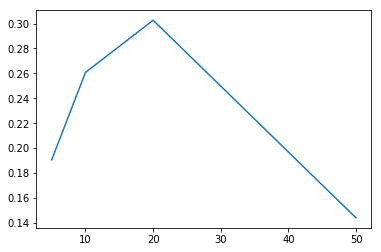

In [21]:
print "Highest MAP {} for n_clusters = {}".format(max(maps), clusters[argmax(maps)]) #MeanAveragePrecision
print maps
plot(clusters, maps)

Lowest RMSE 0.743286908078 for n_clusters = 50
[0.99558891047149289, 0.93080339119900557, 0.86582702702701975, 0.74328690807799447]


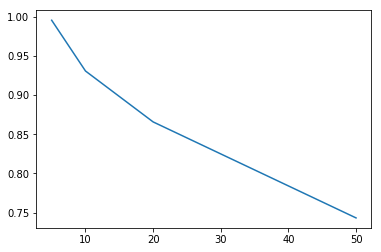

In [22]:
print "Lowest RMSE {} for n_clusters = {}".format(min(rmses), clusters[argmin(rmses)])
print rmses
plot(clusters, rmses)